
# **Calculating WMD and Cosine Score for JSTOR Labeled Articles**



Computational Literature Review

Creator: Nancy Xu

Date created: September 6, 2022

Date last modified: November 26, 2022

This notebook:

- calculates Word Mover's Distance (using a gensim Word2Vec model) between an article and core seed terms
- calculates cosine similarity between an article (represented by average of Word2Vec embeddings of its tokens) and average vector of core seed terms (represented by a Word2Vec embedding)
- compares the distribution of WMD scores and cosine similarity scores for each positive/negative perspective


Files used:
- labeled data
    - `models_storage/preprocessed_texts/training_relational_preprocessed_100321.pkl`
    - `models_storage/preprocessed_texts/training_demographic_preprocessed_100321.pkl`
    - `models_storage/preprocessed_texts/training_cultural_preprocessed_100321.pkl`
- seed terms:
    - `demographic_core.txt`
    - `relational_core.txt`
    - `cultural_core.txt`
    
- word2vec phased model
    - `models_storage/tree/master/w2v_models/word2vec_phrased_filtered_300d_2020_sept5.bin`
    
Other dependencies:
 - CWMD metrics (`pos_cult_full_cwmd_df.csv` and other cwmd csv's)  are generated by `embeddings/word_movers_distance/calculate_cwmd.Rmd`
 
Files outputted:
- `pos_cult_full_3_metrics_df.csv` and other csv's (containing normalized scores for cwmd, wmd, cos)

In [1]:
import pandas as pd
import gensim
import pickle
import os
import re
import ast
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from sklearn import utils
cores = multiprocessing.cpu_count()
import gensim
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from numpy import dot, absolute
from numpy.linalg import norm

## Text preprocessing 

Load in and preprocess dataframes for each perspective.

In [2]:
# os.chdir('/home/jovyan/work/models_storage/preprocessed_texts')
def open_test_data(path):
    return open(path, 'rb')
with open_test_data('/home/jovyan/work/models_storage/preprocessed_texts/training_relational_preprocessed_100321.pkl') as f:
    rela = pickle.load(f)

with open_test_data('/home/jovyan/work/models_storage/preprocessed_texts/training_demographic_preprocessed_100321.pkl') as f:
    demog = pickle.load(f)

with open_test_data('/home/jovyan/work/models_storage/preprocessed_texts/training_cultural_preprocessed_100321.pkl') as f:
    cult = pickle.load(f)
    

import itertools
full_text = []

for i in cult['text']:
    joined = list(itertools.chain(*i))
    full_text.append(" ".join(joined))

full_text_demog = []
for i in demog['text']:
    joined = list(itertools.chain(*i))
    full_text_demog.append(" ".join(joined))

full_text_rela = []
for j in rela['text']:
    joined = list(itertools.chain(*j))
    full_text_rela.append(" ".join(joined))

cult['full_text'] = full_text
demog['full_text'] = full_text_demog
# orgs['full_text'] = full_text_orgs
rela['full_text'] = full_text_rela

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nancyxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


remove html tags

In [ ]:
def remove_tags(article):
    article = re.sub('<plain_text> <page sequence="1">', '', article)
    article = re.sub(r'</page>(\<.*?\>)', ' \n ', article)
    # xml tags
    article = re.sub(r'<.*?>', '', article)
    article = re.sub(r'<body.*\n\s*.*\s*.*>', '', article)
    return article

tags_removed = [remove_tags(art) for art in cult['full_text']]
tags_removed_demog = [remove_tags(art) for art in demog['full_text']]
# tags_removed_org = [remove_tags(art) for art in orgs['full_text']]
tags_removed_rela = [remove_tags(art) for art in rela['full_text']]
cult['text_no_tags'] = tags_removed
demog['text_no_tags'] = tags_removed_demog
# orgs['text_no_tags'] = tags_removed_org
rela['text_no_tags'] = tags_removed_rela


preporcess the text to remove stop words, punctuations

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['one', 'two', 'three', 'amp', 'may', 'can', 'new', 'also', 'and'])

import string
import re
import nltk

def word_process(tt):
    """
    helper function to lower text, remove stop words, numbers, and empty 
    """
    
    tt = tt.lower()
    
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~=\n'''
    # Removing punctuations in string 
    # Using loop + punctuation string 


    for ele in tt:  
        if ele in punc:  
            tt = tt.replace(ele, " ")  

    # read tokens
    tokens = tt.split()
    lst = [token.translate(punc).lower() for token in tokens ]
    
    #remove stop words
    filtered = []
    for i in lst:
        if i not in stop_words:
            filtered.append(i)
    
    # removing singular numbers and singular letters
    pattern = '[0-9]'
    filtered = [re.sub(pattern, '', i) for i in filtered] 
    new = []
    for inp in filtered:
        new.append(' '.join( [w for w in inp.split() if len(w)>1] ))
        
    # filter out empty strings 
    new = [i for i in new if i] 

    dt = [d.split() for d in new]
    
  
    st = ''
    for i in dt:
        st = st + " " + i[0]
    return st
    

In [ ]:
cult['processed']  =  cult['text_no_tags'].apply(word_process)
rela['processed']  =  rela['text_no_tags'].apply(word_process)
demog['processed']  =  demog['text_no_tags'].apply(word_process)

cult_pos = cult[cult['cultural_score']==1]
cult_neg = cult[cult['cultural_score']==0]

rela_pos = rela[rela['relational_score']==1]
rela_neg = rela[rela['relational_score']==0]

demog_pos = demog[demog['demographic_score']==1]
demog_neg = demog[demog['demographic_score']==0]


In [27]:
pos_cult = cult[cult['cultural_score']==1].reset_index()
neg_cult = cult[cult['cultural_score']==0].reset_index()

pos_rela = rela[rela['relational_score']==1].reset_index()
neg_rela = rela[rela['relational_score']==0].reset_index()

pos_demog = demog[demog['demographic_score']==1].reset_index()
neg_demog = demog[demog['demographic_score']==0].reset_index()


In [22]:
cult_pos.to_csv('cult_pos_full.csv')
cult_neg.to_csv('cult_neg_full.csv')

In [24]:
rela_pos.to_csv('rela_pos_full.csv')
rela_neg.to_csv('rela_neg_full.csv')

In [25]:
demog_pos.to_csv('demog_pos_full.csv')
demog_neg.to_csv('demog_neg_full.csv')

load in pretrained phrased w2v model

In [92]:
w2v=Word2Vec.load('word2vec_phrased_filtered_300d_2020_sept5.bin')

## Compute WMD between an article and perspective seed terms

reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html

In [93]:
def calc_wmd(a,b):
    return w2v.wmdistance(a,b)

In [94]:
def read_txt_lst(file):
    txt_file = open(file, "r")
    file_content = txt_file.read()
    # print("The file content are: ", file_content)

    content_list = file_content.split("\n")
    txt_file.close()
    return content_list

In [95]:
dem_core=read_txt_lst('demographic_core.txt')
rela_core=read_txt_lst('relational_core.txt')
cult_core = read_txt_lst('cultural_core.txt')

In [96]:
dem_core=[re.sub(r'\s','_',x) for x in dem_core]
rela_core=[re.sub(r'\s','_',x) for x in rela_core]
cult_core=[re.sub(r'\s','_',x) for x in cult_core]

In [97]:
from nltk.tokenize import word_tokenize

In [33]:
def get_sims_with_perspective(article):
  """
  get wmd similarity between this article and the core terms of each perspective
  """

  ## first build bigram from the article

  article_tokens = article.split()

#   article_tokens = word_tokenize(article)
    
  dem_score = calc_wmd(article_tokens,(dem_core))
  rela_score = calc_wmd(article_tokens,(rela_core))
  cult_score = calc_wmd(article_tokens,(cult_core))
  return (dem_score,rela_score,cult_score)

In [37]:
get_sims_with_perspective(cult_pos.loc[0,'processed'])

/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_50075/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)


(4.295224225608303, 4.103406504450474, 4.014661249573525)

In [34]:
from tqdm import tqdm
tqdm.pandas()

def get_sim_perspective(df):

    """
    returns modified df with extra columns dem_score,rela_score,cult_score
    denoting the wmd score calculated for each article.
    """
    tqdm.pandas()

    results=df['processed'].progress_apply(lambda x:get_sims_with_perspective(x))
    dem_scores = [i[0] for i in results]
    rela_scores = [i[1] for i in results]
    cult_scores = [i[2] for i in results]
    df['dem_scores'] = dem_scores
    df['rela_scores'] = rela_scores
    df['cult_scores']= cult_scores
    return df

In [37]:
pos_cult = get_sim_perspective(cult_pos)
neg_cult = get_sim_perspective(cult_neg)

  0%|                                                   | 0/234 [00:00<?, ?it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
  0%|                                                   | 0/475 [00:00<?, ?it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
100%|███████████████████████████████████████| 475/475 [2:32:28<00:00, 19.26s/it]


In [ ]:
pos_cult.to_csv('pos_cult_full_scores.csv')
neg_cult.to_csv('neg_cult_full_scores.csv')

In [ ]:
pos_demog = get_sim_perspective(demog_pos)
neg_demog = get_sim_perspective(demog_neg)


  0%|                                                   | 0/256 [00:00<?, ?it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
  0%|                                           | 1/477 [00:00<00:51,  9.31it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
100%|███████████████████████████████████████| 477/477 [2:47:09<00:00, 21.03s/it]


In [ ]:
pos_demog.to_csv('pos_demog_full_scores.csv')
neg_demog.to_csv('neg_demog_full_scores.csv')

In [ ]:

pos_rela = get_sim_perspective(rela_pos)
neg_rela = get_sim_perspective(rela_neg)

  0%|▏                                          | 1/287 [00:00<00:31,  9.21it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
  0%|                                                   | 0/420 [00:00<?, ?it/s]/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_14489/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
 23%|█████████▏                              | 97/420 [39:02<1:11:08, 13.22s/it]

In [ ]:
pos_rela.to_csv('pos_rela_full_scores.csv')
neg_rela.to_csv('neg_rela_full_scores.csv')

In [207]:
pos_demog = pd.read_csv('pos_demog_full_scores.csv')
neg_demog= pd.read_csv('neg_demog_full_scores.csv')
pos_cult = pd.read_csv('pos_cult_full_scores.csv')
neg_cult= pd.read_csv('neg_cult_full_scores.csv')
pos_rela = pd.read_csv('pos_rela_full_scores.csv')
neg_rela= pd.read_csv('neg_rela_full_scores.csv')

In [208]:
pos_cult=pos_cult.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_cult=neg_cult.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

pos_demog=pos_demog.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_demog=neg_demog.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

pos_rela=pos_rela.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})
neg_rela=neg_rela.rename(columns={'dem_scores':'dem_wmd', 'rela_scores':'rela_wmd', 'cult_scores':'cult_wmd'})

## Calculate cosine similarity score between the article and each perspective

Using Word2Vec to get vector representations of the text in each jstor article, average them to get the article embedding, then calculate cosine similarity between the embedding of each article and average w2v vector for each perspective.

reference: https://github.com/h2researchgroup/embeddings/blob/main/preprocessing/cosine_values_calculate_word2vec.py

In [209]:
cult_core_embs=[]
for x in cult_core:
  try:
    cult_core_embs.append(w2v.wv[x])
  except:
    pass


In [210]:
demog_core_embs=[]
for x in dem_core:
  try:
    demog_core_embs.append(w2v.wv[x])
  except:
    pass


In [211]:
rela_core_embs=[]
for x in rela_core:
  try:
    rela_core_embs.append(w2v.wv[x])
  except:
    pass


In [212]:
import numpy as np
rela_core_embs_mean = np.mean(rela_core_embs, axis=0)
cult_core_embs_mean = np.mean(cult_core_embs, axis=0)
demog_core_embs_mean = np.mean(demog_core_embs, axis=0)

In [213]:
def doc_words_cosine(doc):
    """
  doc = str of text
  get cosine similarity scores between the document embedding and average emb of the core terms in each perspective.
  """
#     ss = [doc.split()]
#     bb = build_phrases(ss)
#     pb = [bb[i] for i in ss][0]
    tokens = doc.split()
    article_embs=[]
    for k in tokens:
      try:
        article_embs.append(w2v.wv[k])
      except:
        pass
    doc_vec = np.mean(np.array(article_embs), axis=0)
    cult_sim = absolute(dot(doc_vec, cult_core_embs_mean)/(norm(doc_vec)*norm(cult_core_embs_mean)))
    rela_sim = absolute(dot(doc_vec, rela_core_embs_mean)/(norm(doc_vec)*norm(rela_core_embs_mean)))
    demog_sim = absolute(dot(doc_vec, demog_core_embs_mean)/(norm(doc_vec)*norm(demog_core_embs_mean)))
    return (demog_sim,rela_sim,cult_sim)

In [214]:
def apply_doc_words_cosine(df):

  """
  applies doc_words_cosine on the processed texts in each df
  returns modified df with new columns dem_sim,rela_sim,cult_sim
  """

  results=df['processed'].apply(lambda x:doc_words_cosine(x))
  dem_scores = [i[0] for i in results]
  rela_scores = [i[1] for i in results]
  cult_scores = [i[2] for i in results]
  df['dem_sim'] = dem_scores
  df['rela_sim'] = rela_scores
  df['cult_sim']= cult_scores

  return df

In [215]:
pos_cult = apply_doc_words_cosine(pos_cult)
neg_cult = apply_doc_words_cosine(neg_cult)

pos_demog = apply_doc_words_cosine(pos_demog)
neg_demog = apply_doc_words_cosine(neg_demog)

pos_rela = apply_doc_words_cosine(pos_rela)
neg_rela = apply_doc_words_cosine(neg_rela)

To classify an article with WMD, get the perspective with the smallest distance.

In [216]:
pos_rela['classified_perspective_wmd']=pos_rela.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_rela['classified_perspective_wmd']=neg_rela.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
pos_cult['classified_perspective_wmd']=pos_cult.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_cult['classified_perspective_wmd']=neg_cult.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
pos_demog['classified_perspective_wmd']=pos_demog.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)
neg_demog['classified_perspective_wmd']=neg_demog.apply(lambda x:np.argmin([x.dem_wmd,x.rela_wmd,x.cult_wmd]),axis=1)

In [217]:
perspective_dict={0:'demographic', 1:'relational', 2:'cultural'}

In [218]:
pos_rela['classified_perspective_wmd'] = pos_rela['classified_perspective_wmd'].replace(perspective_dict)
neg_rela['classified_perspective_wmd'] = neg_rela['classified_perspective_wmd'].replace(perspective_dict)
pos_cult['classified_perspective_wmd'] = pos_cult['classified_perspective_wmd'].replace(perspective_dict)
neg_cult['classified_perspective_wmd'] = neg_cult['classified_perspective_wmd'].replace(perspective_dict)
pos_demog['classified_perspective_wmd'] = pos_demog['classified_perspective_wmd'].replace(perspective_dict)
neg_demog['classified_perspective_wmd'] = neg_demog['classified_perspective_wmd'].replace(perspective_dict)

To classify an article with cosine similarity, get the perspective with the biggest cosine similarity.

In [219]:
pos_rela['classified_perspective_cos']=pos_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_rela['classified_perspective_cos']=neg_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_cult['classified_perspective_cos']=pos_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_cult['classified_perspective_cos']=neg_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_demog['classified_perspective_cos']=pos_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_demog['classified_perspective_cos']=neg_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)

In [220]:
pos_rela['classified_perspective_cos'] = pos_rela['classified_perspective_cos'].replace(perspective_dict)
neg_rela['classified_perspective_cos'] = neg_rela['classified_perspective_cos'].replace(perspective_dict)
pos_cult['classified_perspective_cos'] = pos_cult['classified_perspective_cos'].replace(perspective_dict)
neg_cult['classified_perspective_cos'] = neg_cult['classified_perspective_cos'].replace(perspective_dict)
pos_demog['classified_perspective_cos'] = pos_demog['classified_perspective_cos'].replace(perspective_dict)
neg_demog['classified_perspective_cos'] = neg_demog['classified_perspective_cos'].replace(perspective_dict)

In [221]:
pos_cult=pos_cult.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_cult=neg_cult.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

pos_demog=pos_demog.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_demog=neg_demog.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

pos_rela=pos_rela.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})
neg_rela=neg_rela.rename(columns={'dem_sim':'dem_cos_sim', 'rela_sim':'rela_cos_sim', 'cult_sim':'cult_cos_sim'})

In [126]:
# from sklearn.preprocessing import normalize
# def normalize_invert_wmd(df):
#     """
#     normalize the wmd, then invert it (1- normalized wmd),
#     also normalize cosine simiarlity score.
    
#     """
#     dem_wmd=df.dem_wmd
#     rela_wmd=df.rela_wmd
#     cult_wmd=df.cult_wmd
    
#     dem_cos = df.dem_cos_sim
#     rela_cos = df.rela_cos_sim
#     cult_cos = df.cult_cos_sim
    
#     normalized_dem_wmd,normalized_rela_wmd,normalized_cult_wmd = [],[],[]
#     normalized_dem_cos,normalized_rela_cos,normalized_cult_cos = [],[],[]
    
#     for i in np.arange(len(df)):
      
#         normalized_inverted_3_scores_wmd = 1 - normalize([[dem_wmd[i],rela_wmd[i], cult_wmd[i]]])
# #         print(normalized_inverted_3_scores)
#         normalized_dem_wmd.append(normalized_inverted_3_scores_wmd[0][0])
#         normalized_rela_wmd.append(normalized_inverted_3_scores_wmd[0][1])
#         normalized_cult_wmd.append(normalized_inverted_3_scores_wmd[0][2])
        
  
#         normalized_inverted_3_scores_cos = normalize([[dem_cos[i],rela_cos[i], cult_cos[i]]])
        
#         normalized_dem_cos.append(normalized_inverted_3_scores_cos[0][0])
#         normalized_rela_cos.append(normalized_inverted_3_scores_cos[0][1])
#         normalized_cult_cos.append(normalized_inverted_3_scores_cos[0][2])
        
#     df['normalized_dem_wmd']=normalized_dem_wmd
#     df['normalized_rela_wmd']=normalized_rela_wmd
#     df['normalized_cult_wmd']=normalized_cult_wmd
    
#     df['normalized_dem_cos']=normalized_dem_cos
#     df['normalized_rela_cos']=normalized_rela_cos
#     df['normalized_cult_cos']=normalized_cult_cos
    
#     return df
        

In [205]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

def normalize_invert_wmd(df):
    """
    normalize (min-max) the wmd, then invert it (1- normalized wmd),
    also normalize cosine simiarlity score.
    
    """
  
    
    data_wmd = df[['dem_wmd', 'rela_wmd', 'cult_wmd']].T.values
    data_cos = df[['dem_cos_sim', 'rela_cos_sim', 'cult_cos_sim']].T.values
    
    scaler = MinMaxScaler()
    
    transformed_wmd = 1-scaler.fit_transform(data_wmd).T
    transformed_cos = scaler.fit_transform(data_cos).T
    
    df['normalized_dem_wmd'],df['normalized_rela_wmd'],df['normalized_cult_wmd'] = transformed_wmd[:, 0],transformed_wmd[:, 1], transformed_wmd[:, 2]
    df['normalized_dem_cos'],df['normalized_rela_cos'],df['normalized_cult_cos'] = transformed_cos[:, 0],transformed_cos[:, 1], transformed_cos[:, 2]
   
    
    return df
        

In [222]:
pos_cult = normalize_invert_wmd(pos_cult.reset_index())
neg_cult = normalize_invert_wmd(neg_cult.reset_index())

pos_demog = normalize_invert_wmd(pos_demog.reset_index())
neg_demog = normalize_invert_wmd(neg_demog.reset_index())

pos_rela = normalize_invert_wmd(pos_rela)
neg_rela = normalize_invert_wmd(neg_rela)

In [223]:
pos_rela

,Unnamed: 0,index,text,relational_score,primary_subject,edited_filename,article_name,full_text,text_no_tags,processed,...,rela_cos_sim,cult_cos_sim,classified_perspective_wmd,classified_perspective_cos,normalized_dem_wmd,normalized_rela_wmd,normalized_cult_wmd,normalized_dem_cos,normalized_rela_cos,normalized_cult_cos
0,0,0,"[['Where', 'Do', 'Interorganizational', 'Netwo...",1.0,Sociology,10.1086_210179,Where Do Interorganizational Networks Come From?,Where Do Interorganizational Networks Come Fro...,Where Do Interorganizational Networks Come Fro...,interorganizational networks come ranjay gula...,...,0.782101,0.640492,relational,relational,0.0,1.000000,0.619898,0.097606,1.000000,0.000000
1,1,2,"[['Between', 'Markets', 'and', 'Politics:', 'O...",1.0,Sociology,10.1086_231084,Between Markets and Politics: Organizational R...,Between Markets and Politics: Organizational R...,Between Markets and Politics: Organizational R...,markets politics organizational responses ref...,...,0.703068,0.625492,cultural,relational,0.0,0.945167,1.000000,0.000000,1.000000,0.075420
2,2,4,"[['<body', 'xmlns:xlink=""http://www..org//xlin...",1.0,Sociology,10.1086_382347,Kinship Networks and Entrepreneurs in China’s ...,"<body xmlns:xlink=""http://www..org//xlink"" xml...",Introduction Economists have long concurred t...,introduction economists long concurred instit...,...,0.677709,0.630969,cultural,relational,0.0,0.890600,1.000000,0.000000,1.000000,0.557904
3,3,7,"[['<body', 'xmlns:xlink=""http://www..org//xlin...",1.0,Sociology,10.1086_657524,Corporate Unity in American Trade Policy: A Ne...,"<body xmlns:xlink=""http://www..org//xlink"" xml...",Introduction The rise of neoliberal trade pol...,introduction rise neoliberal trade policy emb...,...,0.777399,0.632189,relational,relational,0.0,1.000000,0.701453,0.000000,1.000000,0.182401
4,4,10,"[['Negotiated', 'Orders:', 'The', 'Negotiation...",1.0,Sociology,10.1525_si.1994.17.2.165,Negotiated Orders: The Negotiation of Directiv...,Negotiated Orders: The Negotiation of Directiv...,Negotiated Orders: The Negotiation of Directiv...,negotiated orders negotiation directives para...,...,0.539144,0.556231,cultural,cultural,0.0,0.572763,1.000000,0.000000,0.756025,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,282,929,"[['SOCIAL', 'RESOURCES', 'AND', 'STRENGTH', 'O...",1.0,Sociology,10.2307_2095260,Social Resources and Strength of Ties: Structu...,SOCIAL RESOURCES AND STRENGTH OF TIES: STRUCTU...,SOCIAL RESOURCES AND STRENGTH OF TIES: STRUCTU...,social resources strength ties structural fac...,...,0.658202,0.565344,cultural,relational,0.0,0.896008,1.000000,0.000000,1.000000,0.106969
283,283,930,"[['Work', 'and', 'Friendship', 'Ties', 'in', '...",1.0,Management & Organizational Behavior,10.2307_2392493,Work and Friendship Ties in Organizations: A C...,Work and Friendship Ties in Organizations: Com...,Work and Friendship Ties in Organizations: Com...,work friendship ties organizations comparativ...,...,0.712364,0.626875,relational,relational,0.0,1.000000,0.895438,0.000000,1.000000,0.296798
284,284,931,"[['EMBEDDEDNESS', 'IN', 'THE', 'MAKING', 'OF',...",1.0,Sociology,10.2307_2657252,Embeddedness in the Making of Financial Capita...,EMBEDDEDNESS IN THE MAKING OF FINANCIAL CAPITA...,EMBEDDEDNESS IN THE MAKING OF FINANCIAL CAPITA...,embeddedness making financial capital social ...,...,0.764191,0.618817,relational,relational,0.0,1.000000,0.768337,0.000000,1.000000,0.066505
285,285,932,"[['Role', 'as', 'Resource', 'in', 'the', 'Holl...",1.0,Sociology,10.2307_2781378,Role as Resource in the Hollywood Film Industry,Role as Resource in the Hollywood Film Industr...,Role as Resource in the Hollywood Film Industr...,role resource hollywood film industryl wayne ...,...,0.669723,0.641126,cultural,relational,0.0,0.669988,1.000000,0.000000,1.000000,0.579856


In [225]:
pos_rela.columns

Index(['Unnamed: 0', 'index', 'text', 'relational_score', 'primary_subject',
       'edited_filename', 'article_name', 'full_text', 'text_no_tags',
       'processed', 'dem_wmd', 'rela_wmd', 'cult_wmd', 'dem_cos_sim',
       'rela_cos_sim', 'cult_cos_sim', 'classified_perspective_wmd',
       'classified_perspective_cos', 'normalized_dem_wmd',
       'normalized_rela_wmd', 'normalized_cult_wmd', 'normalized_dem_cos',
       'normalized_rela_cos', 'normalized_cult_cos'],
      dtype='object')

In [226]:
keep_cols = ['edited_filename', 'article_name','full_text',
             'processed','classified_perspective_wmd','classified_perspective_cos', 
            'dem_wmd', 'rela_wmd', 'cult_wmd', 'dem_cos_sim', 'rela_cos_sim', 'cult_cos_sim',
       'normalized_dem_wmd','normalized_rela_wmd', 'normalized_cult_wmd', 
       'normalized_dem_cos','normalized_rela_cos', 'normalized_cult_cos']

In [227]:
pos_cult = pos_cult[keep_cols]
neg_cult = neg_cult[keep_cols]
pos_rela = pos_rela[keep_cols]
neg_rela = neg_rela[keep_cols]
pos_demog = pos_demog[keep_cols]
neg_demog = neg_demog[keep_cols]

In [228]:
pos_cult.to_csv('pos_cult_full_wmd_cos.csv')
neg_cult.to_csv('neg_cult_full_wmd_cos.csv')
pos_demog.to_csv('pos_demog_full_wmd_cos.csv')
neg_demog.to_csv('neg_demog_full_wmd_cos.csv')
pos_rela.to_csv('pos_rela_full_wmd_cos.csv')
neg_rela.to_csv('neg_rela_full_wmd_cos.csv')

In [307]:
pos_cult=pd.read_csv('pos_cult_full_wmd_cos.csv')
neg_cult=pd.read_csv('neg_cult_full_wmd_cos.csv')
pos_demog=pd.read_csv('pos_demog_full_wmd_cos.csv')
neg_demog=pd.read_csv('neg_demog_full_wmd_cos.csv')
pos_rela=pd.read_csv('pos_rela_full_wmd_cos.csv')
neg_rela=pd.read_csv('neg_rela_full_wmd_cos.csv')

In [308]:
pos_cult_full=pd.read_csv('pos_cult_full_cwmd_df.csv')
neg_cult_full=pd.read_csv('neg_cult_full_cwmd_df.csv')
pos_demog_full = pd.read_csv('pos_dem_full_cwmd_df.csv')
neg_demog_full = pd.read_csv('neg_dem_full_cwmd_df.csv')
pos_rela_full = pd.read_csv('pos_rela_full_cwmd_df.csv')
neg_rela_full = pd.read_csv('neg_dem_full_cwmd_df.csv')

In [309]:
import numpy as np
from sklearn.preprocessing import normalize

def normalize_cwmd_score(df):

#     normalized_dem_cwmd,normalized_rela_cwmd,normalized_cult_cwmd = [],[],[]
#     for i in np.arange(len(df)):

#         dem_cwmd = df.dem_cwmd_scores
#         cult_cwmd = df.cult_cwmd_scores
#         rela_cwmd = df.rela_cwmd_scores
#         scores_array = np.array([dem_cwmd[i],cult_cwmd[i], rela_cwmd[i]])
#         min_val = min(scores_array)
#         shifted_scores_array = scores_array + np.abs(min_val) + 0.1
#         normalized_inverted_3_scores_cwmd = normalize([[shifted_scores_array[0],shifted_scores_array[1], shifted_scores_array[2]]])
#         normalized_dem_cwmd.append(1-normalized_inverted_3_scores_cwmd[0][0])
#         normalized_cult_cwmd.append(1-normalized_inverted_3_scores_cwmd[0][1])
#         normalized_rela_cwmd.append(1-normalized_inverted_3_scores_cwmd[0][2])
    
    data_cwmd = df[['dem_cwmd_scores', 'rela_cwmd_scores', 'cult_cwmd_scores']].T.values
    
    scaler = MinMaxScaler()
    
    transformed_cwmd = 1-scaler.fit_transform(data_cwmd).T
 
    
    df['normalized_dem_cwmd'],df['normalized_rela_cwmd'],df['normalized_cult_cwmd'] = transformed_cwmd[:, 0],transformed_cwmd[:, 1], transformed_cwmd[:, 2]
   
    
    return df

In [310]:
pos_cult_full = normalize_cwmd_score(pos_cult_full)
neg_cult_full = normalize_cwmd_score(neg_cult_full)
pos_demog_full = normalize_cwmd_score(pos_demog_full)
neg_demog_full = normalize_cwmd_score(neg_demog_full)
pos_rela_full = normalize_cwmd_score(pos_rela_full)
neg_rela_full = normalize_cwmd_score(neg_rela_full)

In [316]:
keep_cols = ['edited_filename',
 'article_name',
 'full_text',
 'processed',
 'classified_perspective_wmd',
 'classified_perspective_cos',
 'dem_wmd',
 'rela_wmd',
 'cult_wmd',
 'dem_cos_sim',
 'rela_cos_sim',
 'cult_cos_sim',
 'normalized_dem_wmd',
 'normalized_rela_wmd',
 'normalized_cult_wmd',
 'normalized_dem_cos',
 'normalized_rela_cos',
 'normalized_cult_cos','cult_cwmd_scores', 'dem_cwmd_scores', 'rela_cwmd_scores',
       'normalized_dem_cwmd', 'normalized_rela_cwmd', 'normalized_cult_cwmd' ]

In [321]:
pos_cult = pos_cult.merge(pos_cult_full,on = 'edited_filename',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')[keep_cols]

In [322]:
neg_cult = neg_cult.merge(neg_cult_full,on = 'edited_filename',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')[keep_cols]


In [323]:
pos_rela = pos_rela.merge(pos_rela_full,on = 'edited_filename',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')[keep_cols]
neg_rela = neg_rela.merge(neg_rela_full,on = 'edited_filename',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')[keep_cols]


In [326]:
pos_demog = pos_demog.merge(pos_demog_full,on = 'edited_filename',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')[keep_cols]
neg_demog = neg_demog.merge(neg_demog_full,on = 'edited_filename',suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')[keep_cols]


In [327]:
pos_cult.to_csv('pos_cult_full_3_metrics_df.csv')
neg_cult.to_csv('neg_cult_full_3_metrics_df.csv')

pos_demog.to_csv('pos_demog_full_3_metrics_df.csv')
neg_demog.to_csv('neg_demog_full_3_metrics_df.csv')

pos_rela.to_csv('pos_rela_full_3_metrics_df.csv')
neg_rela.to_csv('neg_rela_full_3_metrics_df.csv')

## Inspecting Distribution of Similarity Metrics

## demographic

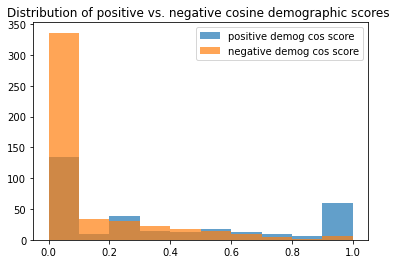

In [328]:
import matplotlib.pyplot as plt
plt.hist(pos_demog['normalized_dem_cos'], label = 'positive demog cos score', alpha = 0.7)
plt.hist(neg_demog['normalized_dem_cos'], label = 'negative demog cos score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine demographic scores ')
plt.legend()
plt.show()

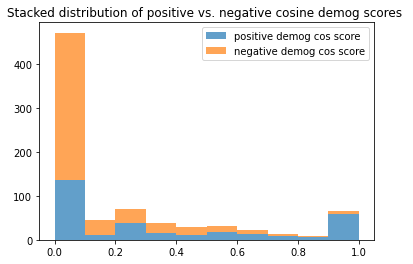

In [329]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive demog cos score','negative demog cos score']

plt.hist([pos_demog['normalized_dem_cos'], neg_demog['normalized_dem_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative cosine demog scores ')
plt.legend()



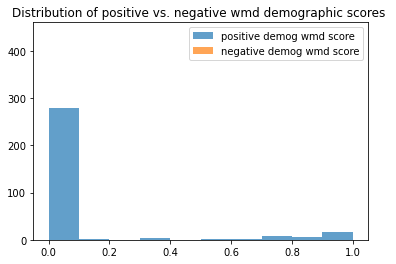

In [331]:
plt.hist(pos_demog['normalized_dem_wmd'], label = 'positive demog wmd score', alpha = 0.7)
plt.hist(neg_demog['normalized_dem_wmd'], label = 'negative demog wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd demographic scores ')
plt.legend()
plt.show()

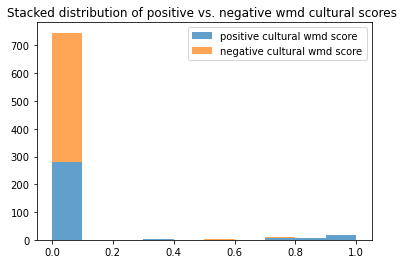

In [332]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural wmd score','negative cultural wmd score']

plt.hist([pos_demog['normalized_dem_wmd'], neg_cult['normalized_dem_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd cultural scores ')
plt.legend()



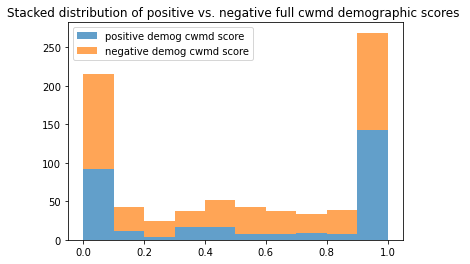

In [333]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive demog cwmd score','negative demog cwmd score']

plt.hist([pos_demog['normalized_dem_cwmd'], neg_demog['normalized_dem_cwmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative full cwmd demographic scores ')
plt.legend()



## cultural

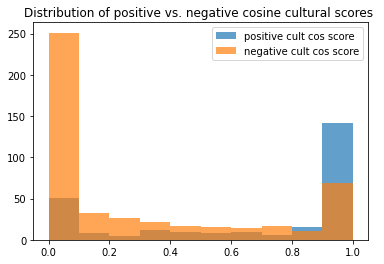

In [334]:
plt.hist(pos_cult['normalized_cult_cos'], label = 'positive cult cos score', alpha = 0.7)
plt.hist(neg_cult['normalized_cult_cos'], label = 'negative cult cos score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine cultural scores ')
plt.legend()
plt.show()

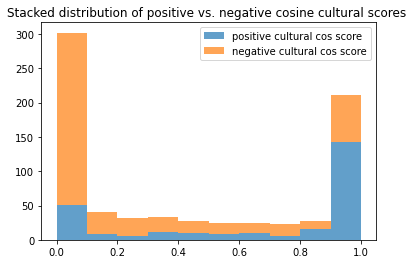

In [335]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural cos score','negative cultural cos score']

plt.hist([pos_cult['normalized_cult_cos'], neg_cult['normalized_cult_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative cosine cultural scores ')
plt.legend()



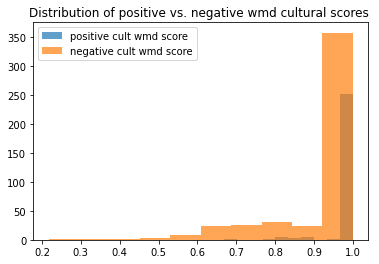

In [336]:
plt.hist(pos_cult['normalized_cult_wmd'], label = 'positive cult wmd score', alpha = 0.7)
plt.hist(neg_cult['normalized_cult_wmd'], label = 'negative cult wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd cultural scores ')
plt.legend()
plt.show()

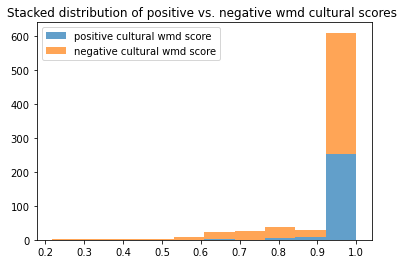

In [337]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural wmd score','negative cultural wmd score']

plt.hist([pos_cult['normalized_cult_wmd'], neg_cult['normalized_cult_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd cultural scores ')
plt.legend()



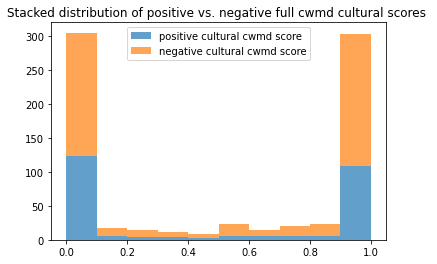

In [338]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive cultural cwmd score','negative cultural cwmd score']

plt.hist([pos_cult['normalized_cult_cwmd'], neg_cult['normalized_cult_cwmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative full cwmd cultural scores ')
plt.legend()



## relational

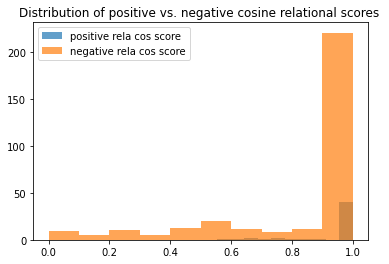

In [339]:
plt.hist(pos_rela['normalized_rela_cos'], label = 'positive rela cos score', alpha = 0.7)
plt.hist(neg_rela['normalized_rela_cos'], label = 'negative rela cos score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine relational scores ')
plt.legend()
plt.show()

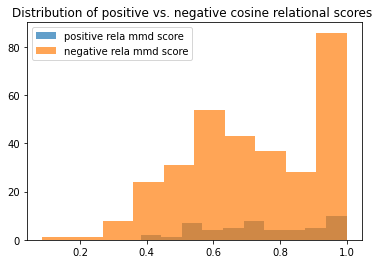

In [340]:
plt.hist(pos_rela['normalized_rela_wmd'], label = 'positive rela mmd score', alpha = 0.7)
plt.hist(neg_rela['normalized_rela_wmd'], label = 'negative rela mmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine relational scores ')
plt.legend()
plt.show()

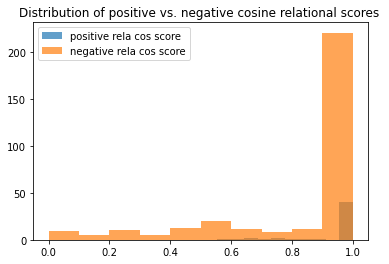

In [341]:
plt.hist(pos_rela['normalized_rela_cos'], label = 'positive rela cos score', alpha = 0.7)
plt.hist(neg_rela['normalized_rela_cos'], label = 'negative rela cos score', alpha = 0.7)
plt.title('Distribution of positive vs. negative cosine relational scores ')
plt.legend()
plt.show()

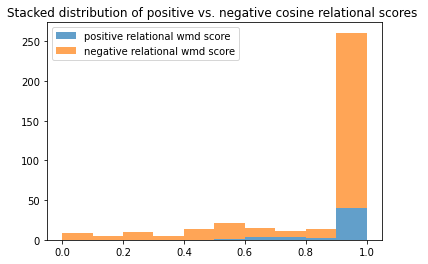

In [342]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive relational wmd score','negative relational wmd score']

plt.hist([pos_rela['normalized_rela_cos'], neg_rela['normalized_rela_cos']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative cosine relational scores ')
plt.legend()



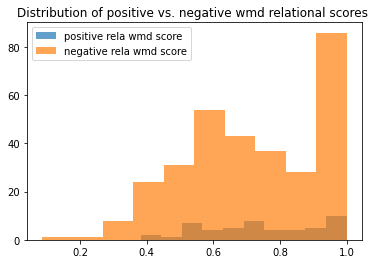

In [343]:
plt.hist(pos_rela['normalized_rela_wmd'], label = 'positive rela wmd score', alpha = 0.7)
plt.hist(neg_rela['normalized_rela_wmd'], label = 'negative rela wmd score', alpha = 0.7)
plt.title('Distribution of positive vs. negative wmd relational scores ')
plt.legend()
plt.show()

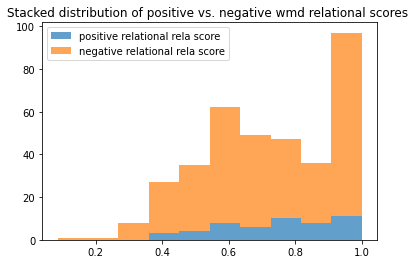

In [344]:
import matplotlib.pyplot as plt
bins = np.arange(0.2,0.5,0.001)
labels = ['positive relational rela score','negative relational rela score']

plt.hist([pos_rela['normalized_rela_wmd'], neg_rela['normalized_rela_wmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative wmd relational scores ')
plt.legend()



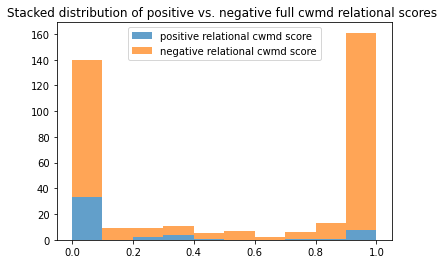

In [345]:
bins = np.arange(0.2,0.5,0.001)
labels = ['positive relational cwmd score','negative relational cwmd score']

plt.hist([pos_rela['normalized_rela_cwmd'], neg_rela['normalized_rela_cwmd']], histtype='bar', alpha = 0.7,stacked=True, label=labels, rwidth=1)
plt.title('Stacked distribution of positive vs. negative full cwmd relational scores ')
plt.legend()



## distribution statistics

For each perspective and each metric (WMD, cosine, CMD), provide mean, standard deviation, max, min, and 95th, 50th (median), and 5th percentiles
Provide that for each distribution non-normalized and normalized with min-max method.

### normalized

In [378]:
def output_distribution_stats(df,metric_col):
    distribution = df[metric_col]
    print(metric_col)
    print('mean            ', np.mean(distribution))
    print('std             ', np.std(distribution))
    print('min             ', np.min(distribution)) 
    print('max             ', np.max(distribution)) 
    print('5th percentile  ', np.percentile(distribution,5)) 
    print('50th percentile ', np.percentile(distribution,50)) 
    print('95th percentile ', np.percentile(distribution,95)) 
    print('================')
    return [np.mean(distribution),np.std(distribution),np.min(distribution),
           np.max(distribution), np.percentile(distribution,5),np.percentile(distribution,50),
            np.percentile(distribution,95)
           
           ]

#### positive rela

In [379]:
pos_rela_cos_dist_stats = output_distribution_stats(pos_rela,'normalized_rela_cos')
pos_rela_wmd_dist_stats = output_distribution_stats(pos_rela,'normalized_rela_wmd')
pos_rela_cwmd_dist_stats = output_distribution_stats(pos_rela,'normalized_rela_cwmd')

normalized_rela_cos
mean             0.9427002046000001
std              0.1188234375327872
min              0.5531635
max              1.0000005
5th percentile   0.67859084
50th percentile  1.0
95th percentile  1.000000275
normalized_rela_wmd
mean             0.7465423113738529
std              0.17432952128708423
min              0.3815734387703742
max              1.0
5th percentile   0.4764160374743743
50th percentile  0.7333410903636324
95th percentile  1.0
normalized_rela_cwmd
mean             0.23774096180442078
std              0.3769933094037931
min              -2.220446049250313e-16
max              1.0
5th percentile   -1.2212453270876718e-16
50th percentile  0.0
95th percentile  1.0


#### negative rela

In [380]:
neg_rela_cos_dist_stats = output_distribution_stats(neg_rela,'normalized_rela_cos')
neg_rela_wmd_dist_stats = output_distribution_stats(neg_rela,'normalized_rela_wmd')
neg_rela_cwmd_dist_stats = output_distribution_stats(neg_rela,'normalized_rela_cwmd')

normalized_rela_cos
mean             0.8469916684217251
std              0.26997798481168245
min              0.0
max              1.000001
5th percentile   0.210017108
50th percentile  1.0
95th percentile  1.0
normalized_rela_wmd
mean             0.7246222439656032
std              0.20825626171407724
min              0.0853948451207351
max              1.0
5th percentile   0.3853768342783318
50th percentile  0.7143216773560201
95th percentile  1.0
normalized_rela_cwmd
mean             0.5725704538540272
std              0.459766012080421
min              -8.881784197001252e-16
max              1.0
5th percentile   0.0
50th percentile  0.8757374119109609
95th percentile  1.0


#### positive demog

In [381]:
pos_demog_cos_dist_stats = output_distribution_stats(pos_demog,'normalized_dem_cos')
pos_demog_wmd_dist_stats = output_distribution_stats(pos_demog,'normalized_dem_wmd')
pos_demog_cwmd_dist_stats = output_distribution_stats(pos_demog,'normalized_dem_cwmd')

normalized_dem_cos
mean             0.34917242799904413
std              0.38645702177949287
min              0.0
max              1.0000005
5th percentile   0.0
50th percentile  0.21868896
95th percentile  1.0
normalized_dem_wmd
mean             0.09117241222179749
std              0.2693997206628344
min              -3.552713678800501e-15
max              1.0
5th percentile   -1.7763568394002505e-15
50th percentile  0.0
95th percentile  0.9339773499165711
normalized_dem_cwmd
mean             0.5768793005128241
std              0.435603593459267
min              -4.440892098500626e-16
max              1.0
5th percentile   0.0
50th percentile  0.7695597106113481
95th percentile  1.0


#### negative demog

In [382]:
neg_demog_cos_dist_stats = output_distribution_stats(neg_demog,'normalized_dem_cos')
neg_demog_wmd_dist_stats = output_distribution_stats(neg_demog,'normalized_dem_wmd')
neg_demog_cwmd_dist_stats = output_distribution_stats(neg_demog,'normalized_dem_cwmd')

normalized_dem_cos
mean             0.11284448829098524
std              0.2081071020133387
min              0.0
max              1.0000002
5th percentile   0.0
50th percentile  0.0
95th percentile  0.5750440299999999
normalized_dem_wmd
mean             -4.282621310923036e-17
std              5.206172579029815e-16
min              -1.7763568394002505e-15
max              3.552713678800501e-15
5th percentile   -1.7763568394002505e-15
50th percentile  0.0
95th percentile  0.0
normalized_dem_cwmd
mean             0.5072504556148575
std              0.3906810576827635
min              -4.440892098500626e-16
max              1.0
5th percentile   0.0
50th percentile  0.5246023501196138
95th percentile  1.0


#### positive cultual

In [383]:
pos_cult_cos_dist_stats = output_distribution_stats(pos_cult,'normalized_cult_cos')
pos_cult_wmd_dist_stats = output_distribution_stats(pos_cult,'normalized_cult_wmd')
pos_cult_cwmd_dist_stats = output_distribution_stats(pos_cult,'normalized_cult_cwmd')

normalized_cult_cos
mean             0.6778773047063432
std              0.401298040201165
min              0.0
max              1.0
5th percentile   0.0
50th percentile  0.9999998800000001
95th percentile  1.0
normalized_cult_wmd
mean             0.9907941746369479
std              0.03968090100442427
min              0.6679362055748559
max              1.0
5th percentile   0.9188263694847646
50th percentile  1.0
95th percentile  1.0
normalized_cult_cwmd
mean             0.47416541598740125
std              0.4707869528248006
min              -8.881784197001252e-16
max              1.0
5th percentile   0.0
50th percentile  0.31426308624590116
95th percentile  1.0


In [384]:
neg_cult_cos_dist_stats = output_distribution_stats(neg_cult,'normalized_cult_cos')
neg_cult_wmd_dist_stats = output_distribution_stats(neg_cult,'normalized_cult_wmd')
neg_cult_cwmd_dist_stats = output_distribution_stats(neg_cult,'normalized_cult_cwmd')

normalized_cult_cos
mean             0.2880642484399997
std              0.3713219156650533
min              0.0
max              1.0
5th percentile   0.0
50th percentile  0.07864618
95th percentile  1.0
normalized_cult_wmd
mean             0.9308435309975684
std              0.13189842766375243
min              0.2170784700219954
max              1.0
5th percentile   0.6384674170210692
50th percentile  1.0
95th percentile  1.0
normalized_cult_cwmd
mean             0.5219629092400123
std              0.45599682668393315
min              -4.440892098500626e-16
max              1.0
5th percentile   -2.220446049250313e-16
50th percentile  0.6235144611067841
95th percentile  1.0


In [385]:
neg_cult_cos_dist_stats

[0.2880642484399997, 0.3713219156650533, 0.0, 1.0, 0.0, 0.07864618, 1.0]

In [387]:
pd.DataFrame({
    'stats': ['mean', 'std', 'min', 'max', '5th percentile', '50th percentile', '95th percentile'],
    
    'pos_rela_cos_dist_stats':pos_rela_cos_dist_stats,
    'pos_rela_wmd_dist_stats':pos_rela_wmd_dist_stats,
    'pos_rela_cwmd_dist_stats':pos_rela_cwmd_dist_stats,
    
    'neg_rela_cos_dist_stats':neg_rela_cos_dist_stats,
    'neg_rela_wmd_dist_stats':neg_rela_wmd_dist_stats,
    'neg_rela_cwmd_dist_stats':neg_rela_cwmd_dist_stats,
    
    'pos_cult_cos_dist_stats':pos_cult_cos_dist_stats,
    'pos_cult_wmd_dist_stats':pos_cult_wmd_dist_stats,
    'pos_cult_cwmd_dist_stats':pos_cult_cwmd_dist_stats,
    
    'neg_cult_cos_dist_stats': neg_cult_cos_dist_stats,
    'neg_cult_wmd_dist_stats':neg_cult_wmd_dist_stats,
    'neg_cult_cwmd_dist_stats':neg_cult_cwmd_dist_stats,
    
    'pos_demog_cos_dist_stats':pos_demog_cos_dist_stats,
    'pos_demog_wmd_dist_stats':pos_demog_wmd_dist_stats,
    'pos_demog_cwmd_dist_stats':pos_demog_cwmd_dist_stats,
    
    'neg_demog_cos_dist_stats':neg_demog_cos_dist_stats,
    'neg_demog_wmd_dist_stats':neg_demog_wmd_dist_stats,
    'neg_demog_cwmd_dist_stats':neg_demog_cwmd_dist_stats,
    
    
}).to_csv('dist_stats.csv')

### non-normalized

In [389]:
pos_rela_cos_dist_stats = output_distribution_stats(pos_rela,'rela_cos_sim')
pos_rela_wmd_dist_stats = output_distribution_stats(pos_rela,'rela_wmd')
pos_rela_cwmd_dist_stats = output_distribution_stats(pos_rela,'rela_cwmd_scores')

rela_cos_sim
mean             0.6870493058000001
std              0.05035165918762111
min              0.54391885
max              0.76330394
5th percentile   0.592797863
50th percentile  0.6994446999999999
95th percentile  0.7435418
rela_wmd
mean             4.001236245216475
std              0.10088694480820874
min              3.822375338493596
max              4.213917166615595
5th percentile   3.8393404325274987
50th percentile  3.995551277644905
95th percentile  4.189611799503707
rela_cwmd_scores
mean             0.4704076823445882
std              0.9258739382194574
min              -1.65666468961304
max              2.01103328345109
5th percentile   -1.61114842319984
50th percentile  0.6045550183285631
95th percentile  1.8355807711645586


In [390]:
neg_rela_cos_dist_stats = output_distribution_stats(neg_rela,'rela_cos_sim')
neg_rela_wmd_dist_stats = output_distribution_stats(neg_rela,'rela_wmd')
neg_rela_cwmd_dist_stats = output_distribution_stats(neg_rela,'rela_cwmd_scores')

rela_cos_sim
mean             0.6320334139936106
std              0.05160436767543854
min              0.4275657
max              0.7488283
5th percentile   0.534028896
50th percentile  0.6382311
95th percentile  0.70780986
rela_wmd
mean             4.089932714242921
std              0.11204285662514589
min              3.741159073660863
max              4.562372418894068
5th percentile   3.938954184735445
50th percentile  4.073497748516126
95th percentile  4.289848271845836
rela_cwmd_scores
mean             -0.2748853048835057
std              0.9411863379232903
min              -3.74491169459266
max              1.66199171033654
5th percentile   -2.11118074468873
50th percentile  -0.13552103333202
95th percentile  1.0614059869361325


In [391]:
pos_cult_cos_dist_stats = output_distribution_stats(pos_cult,'cult_cos_sim')
pos_cult_wmd_dist_stats = output_distribution_stats(pos_cult,'cult_wmd')
pos_cult_cwmd_dist_stats = output_distribution_stats(pos_cult,'cult_cwmd_scores')

cult_cos_sim
mean             0.654929369253731
std              0.05238904834982054
min              0.523076
max              0.7885722
5th percentile   0.56986574
50th percentile  0.654177515
95th percentile  0.7482823099999999
cult_wmd
mean             3.92392936602137
std              0.13844588404921981
min              3.574125607959993
max              4.755310385883764
5th percentile   3.726577648463086
50th percentile  3.9232332650078225
95th percentile  4.11961360312094
cult_cwmd_scores
mean             0.03951269365305483
std              0.9927039388979011
min              -2.23869377734574
max              3.00104012210306
5th percentile   -1.4866743981748338
50th percentile  0.00959005794680605
95th percentile  1.7799081937885721


In [392]:
neg_cult_cos_dist_stats = output_distribution_stats(neg_cult,'cult_cos_sim')
neg_cult_wmd_dist_stats = output_distribution_stats(neg_cult,'cult_wmd')
neg_cult_cwmd_dist_stats = output_distribution_stats(neg_cult,'cult_cwmd_scores')

cult_cos_sim
mean             0.5779438308421054
std              0.06497302681835394
min              0.3575709
max              0.73031163
5th percentile   0.463982501
50th percentile  0.5863528
95th percentile  0.6710822449999999
cult_wmd
mean             4.026883025388621
std              0.11835094221657143
min              3.733413590483957
max              4.554302961884815
5th percentile   3.8569036033115673
50th percentile  4.011501245171489
95th percentile  4.25503601238182
cult_cwmd_scores
mean             -9.321198783589736e-16
std              0.9989468138204881
min              -3.28881410907668
max              2.7725571412029
5th percentile   -1.7742870505491188
50th percentile  0.0452831719301313
95th percentile  1.5202237154539757


In [393]:
pos_demog_cos_dist_stats = output_distribution_stats(pos_demog,'dem_cos_sim')
pos_demog_wmd_dist_stats = output_distribution_stats(pos_demog,'dem_wmd')
pos_demog_cwmd_dist_stats = output_distribution_stats(pos_demog,'dem_cwmd_scores')

dem_cos_sim
mean             0.6091525107961772
std              0.07083982336862207
min              0.46931487
max              0.78559583
5th percentile   0.50184503
50th percentile  0.5976586
95th percentile  0.7228249509999999
dem_wmd
mean             4.19046182143502
std              0.15929574742905608
min              3.730991681052065
max              4.964788083122489
5th percentile   3.9159177226800264
50th percentile  4.204983843372585
95th percentile  4.362352552201568
dem_cwmd_scores
mean             0.08254548949438537
std              0.9998854561742423
min              -1.96212400542049
max              2.8824035866893
5th percentile   -1.369512744260444
50th percentile  -0.0509582799960484
95th percentile  1.92197241533077


In [394]:
neg_demog_cos_dist_stats = output_distribution_stats(neg_demog,'dem_cos_sim')
neg_demog_wmd_dist_stats = output_distribution_stats(neg_demog,'dem_wmd')
neg_demog_cwmd_dist_stats = output_distribution_stats(neg_demog,'dem_cwmd_scores')

dem_cos_sim
mean             0.5731031216561849
std              0.04410043723846588
min              0.3863671
max              0.71023184
5th percentile   0.502443008
50th percentile  0.5727778
95th percentile  0.64547051
dem_wmd
mean             4.267398425360654
std              0.09739879162969746
min              4.028614523501538
max              4.6398636586996425
5th percentile   4.134509675824464
50th percentile  4.259395860963147
95th percentile  4.445961779913202
dem_cwmd_scores
mean             1.4176873046104461e-15
std              0.9989512320135049
min              -3.73553261993526
max              2.8933077229419
5th percentile   -1.98507712624643
50th percentile  0.066843694756562
95th percentile  1.4723063073112217


In [395]:
pd.DataFrame({
    'stats': ['mean', 'std', 'min', 'max', '5th percentile', '50th percentile', '95th percentile'],
    
    'pos_rela_cos_dist_stats':pos_rela_cos_dist_stats,
    'pos_rela_wmd_dist_stats':pos_rela_wmd_dist_stats,
    'pos_rela_cwmd_dist_stats':pos_rela_cwmd_dist_stats,
    
    'neg_rela_cos_dist_stats':neg_rela_cos_dist_stats,
    'neg_rela_wmd_dist_stats':neg_rela_wmd_dist_stats,
    'neg_rela_cwmd_dist_stats':neg_rela_cwmd_dist_stats,
    
    'pos_cult_cos_dist_stats':pos_cult_cos_dist_stats,
    'pos_cult_wmd_dist_stats':pos_cult_wmd_dist_stats,
    'pos_cult_cwmd_dist_stats':pos_cult_cwmd_dist_stats,
    
    'neg_cult_cos_dist_stats': neg_cult_cos_dist_stats,
    'neg_cult_wmd_dist_stats':neg_cult_wmd_dist_stats,
    'neg_cult_cwmd_dist_stats':neg_cult_cwmd_dist_stats,
    
    'pos_demog_cos_dist_stats':pos_demog_cos_dist_stats,
    'pos_demog_wmd_dist_stats':pos_demog_wmd_dist_stats,
    'pos_demog_cwmd_dist_stats':pos_demog_cwmd_dist_stats,
    
    'neg_demog_cos_dist_stats':neg_demog_cos_dist_stats,
    'neg_demog_wmd_dist_stats':neg_demog_wmd_dist_stats,
    'neg_demog_cwmd_dist_stats':neg_demog_cwmd_dist_stats,
    
    
}).to_csv('dist_stats_non_normalized.csv')